## Data Preparation

### Getting data from Alpha Vantage

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.style.use("dark_background")

import numpy as np
import os
import json

from alpha_vantage.timeseries import TimeSeries


config = {
    "alpha_vantage": {
        "key": "6IN7ZPN5592V62VK", # API key
        "symbol": "IBM",
        "outputsize": "full", # full 20+ years
        "key_adjusted_close": "4. close", # adjusted close price for splits/dividends
    },
        "data": {
            "window_size": 20, # use information from past 20 days to predict
            "train_split_size": 0.80,
        }, 
        "plots": {
            "xticks_interval": 90, # show a date every 90 days
            "color_actual": "#ff8000",
            "color_train": "#58F6AF",
            "color_val": "#7CC2FF",
            "color_pred_train": "#3D9970",
            "color_pred_val": "#00529A",
            "color_pred_test": "#FF4136",
        },
        "model": {
            "input_size": 1, # we are only using 1 feature: close price
            "num_lstm_layers": 2,
            "lstm_size": 32, # hidden state dimensionality
            "dropout": 0.2,
        },
        "training": {
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            "batch_size": 64,
            "num_epoch": 100,
            "learning_rate": 1e-2,
            "weight_decay": 1e-2,
            "scheduler_step_size": 40,
    }
}

In [ ]:
def get_data_write_to_json(config):

    data_dict = {}
    
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(symbol=config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"]) # type: ignore

    data_dates = [date for date in data.keys()] # type: ignore
    # print(data_dates[:5])
    # print(data_dates[-5:])
    # dates is in order of recent -> old
    data_dates.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data_dates]
    # print(data_close_price[:5], data_close_price[-5:])    
    
    num_data_points = len(data_dates)
    display_date_range = f"from {data_dates[0]} to {data_dates[-1]}"
    print("Number of data points:", num_data_points, display_date_range)

    data_dict["data_dates"] = data_dates
    data_dict["data_close_price"] = data_close_price
    data_dict["num_data_points"] = num_data_points
    data_dict["display_date_range"] = display_date_range

    with open("stock_data.json", "w") as f:
        json.dump(data_dict, f)
    
get_data_write_to_json(config)

Number of data points: 6490 from 1999-11-01 to 2025-08-20


In [ ]:
def read_data_from_json(file_name):

    with open(file_name, "r") as f:
        data_dict = json.load(f)

    return data_dict["data_dates"], data_dict["data_close_price"], data_dict["num_data_points"], data_dict["display_date_range"]

data_dates, data_close_price, num_data_points, display_date_range = read_data_from_json("stock_data.json")

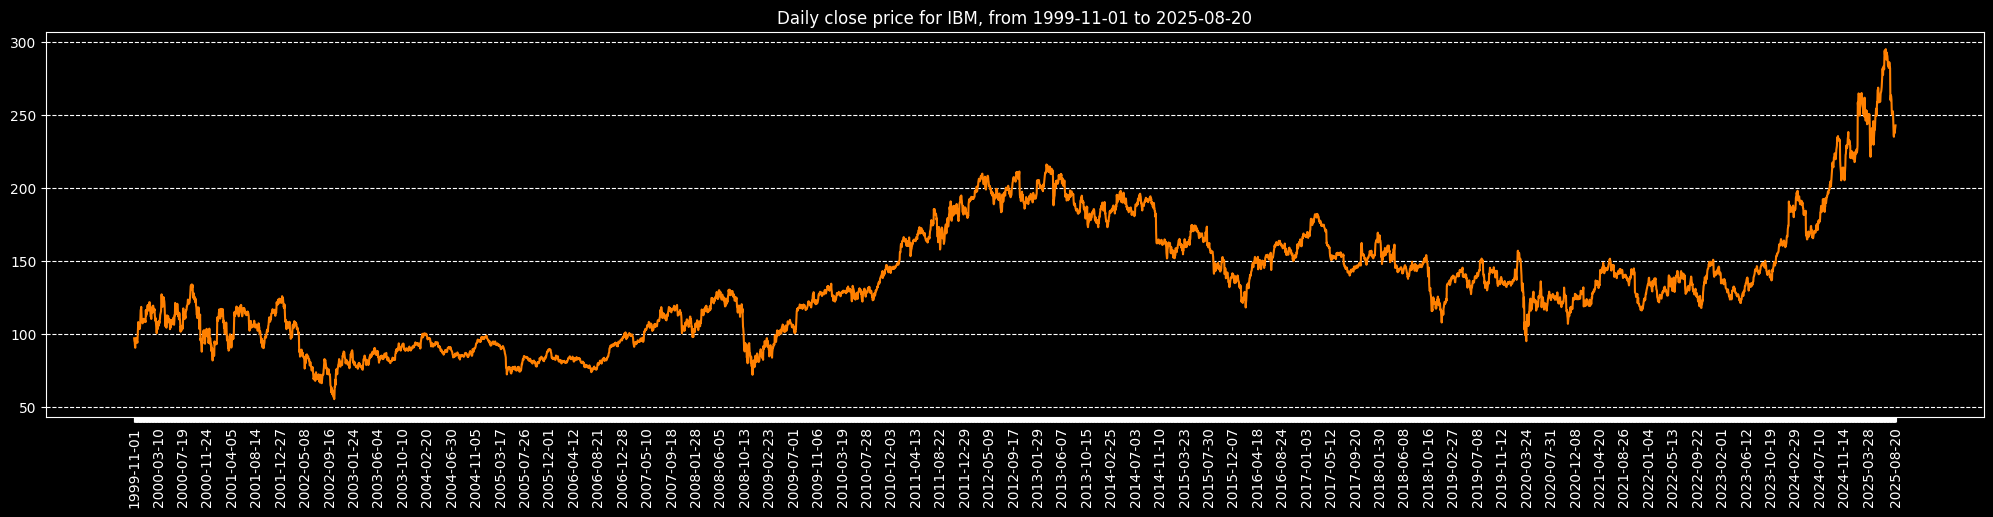

In [13]:
def plot_data(data_dates, data_close_price, num_data_points, display_date_range):
    fig = plt.figure(figsize=(25, 5), dpi=100)
    fig.patch.set_facecolor(color="black")
    plt.plot(data_dates, data_close_price, color=config["plots"]["color_actual"])

    xticks_labels = []
    xticks_interval = config["plots"]["xticks_interval"]

    for i in range(num_data_points):
        # Always include the last data point
        if i == num_data_points - 1:
            xticks_labels.append(data_dates[i])
        # Include every xticks_interval-th point, but avoid ticks too close to the end
        elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
            xticks_labels.append(data_dates[i])
        else:
            xticks_labels.append(None)

    xticks_indices = np.arange(0, len(xticks_labels))
    plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

    plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range}")
    plt.grid(axis="y", linestyle="--")

plot_data(data_dates, data_close_price, num_data_points, display_date_range)

### Normalizing raw data

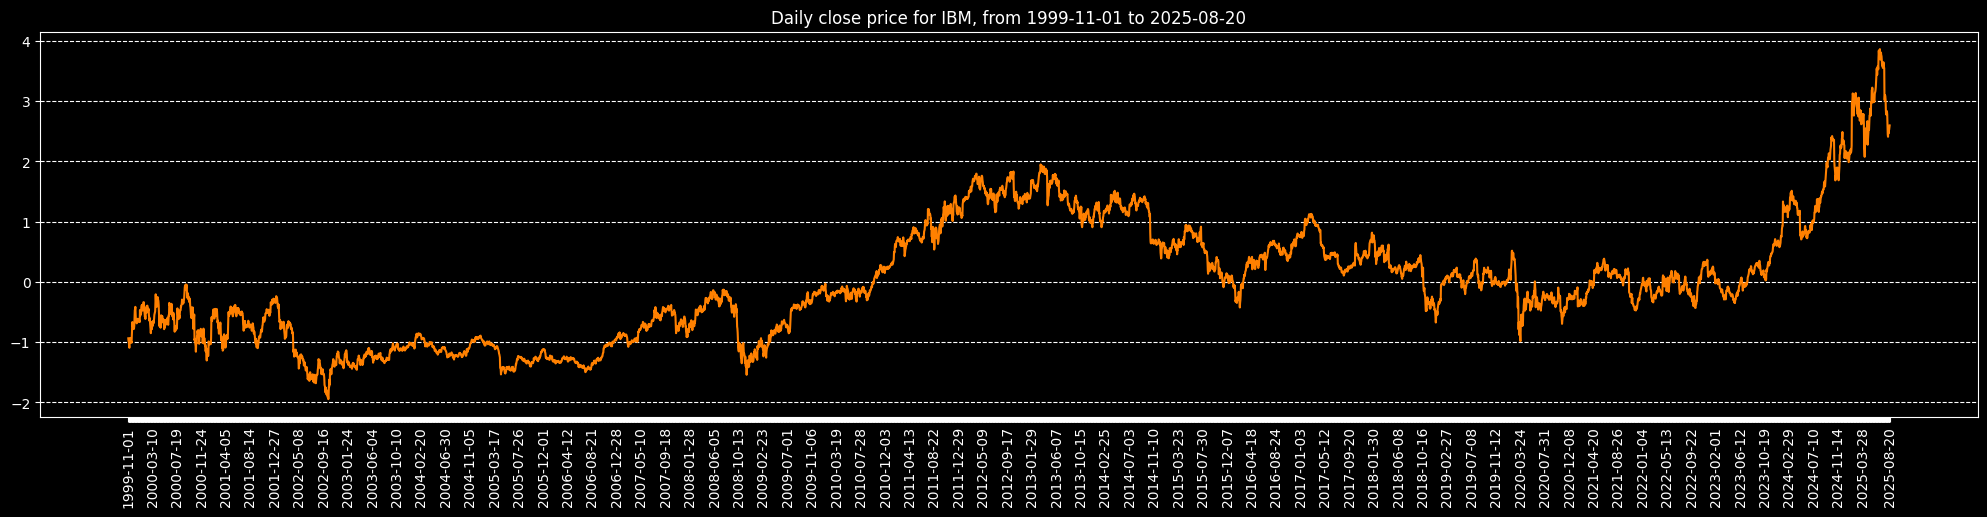

In [14]:
# use standardization
class Normalizer():
    def __init__(self):
        self.mean = None
        self.sd = None

    def standardize(self, data):
        self.mean = np.mean(data, axis=0, keepdims=True)
        self.std = np.std(data, axis=0, keepdims=True)
        return (data - self.mean) / self.std
    
    def inverse_transform(self, data):
        return data * self.std  + self.mean
    
scaler = Normalizer()
normalized_data_close_price = scaler.standardize(data_close_price)
plot_data(data_dates, normalized_data_close_price, num_data_points, display_date_range)

### Train/Val split

In [15]:
def windows_x(data, window_size):
    n_row = data.shape[0] - window_size + 1
    windows = [data[i:i+window_size] for i in range(n_row)]
    windows = np.array(windows) 

    X = windows[:-1] # all except last
    last = windows[-1] # last window, going to use this to predict tomorrow's price

    return X, last

def windows_y(data, window_size):
    return data[window_size:]

data_x, data_x_unseen = windows_x(normalized_data_close_price, config["data"]["window_size"])
data_y = windows_y(normalized_data_close_price, config["data"]["window_size"])

data_x, data_y

(array([[-0.93661436, -0.98363465, -0.99429904, ..., -0.74877561,
         -0.73665698, -0.75628916],
        [-0.98363465, -0.99429904, -1.06240574, ..., -0.73665698,
         -0.75628916, -0.78367726],
        [-0.99429904, -1.06240574, -1.09415655, ..., -0.75628916,
         -0.78367726, -0.77495185],
        ...,
        [ 3.61902079,  3.55236833,  3.55358019, ...,  2.53706956,
          2.46532727,  2.52858652],
        [ 3.55236833,  3.55358019,  3.03247913, ...,  2.46532727,
          2.52858652,  2.52204246],
        [ 3.55358019,  3.03247913,  3.01333169, ...,  2.52858652,
          2.52204246,  2.56639664]], shape=(6470, 20)),
 array([-0.78367726, -0.77495185, -0.73011292, ...,  2.52204246,
         2.56639664,  2.59717796], shape=(6470,)))

In [54]:
split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_y_train = data_y[:split_index]

data_x_val = data_x[split_index:]
data_y_val = data_y[split_index:]

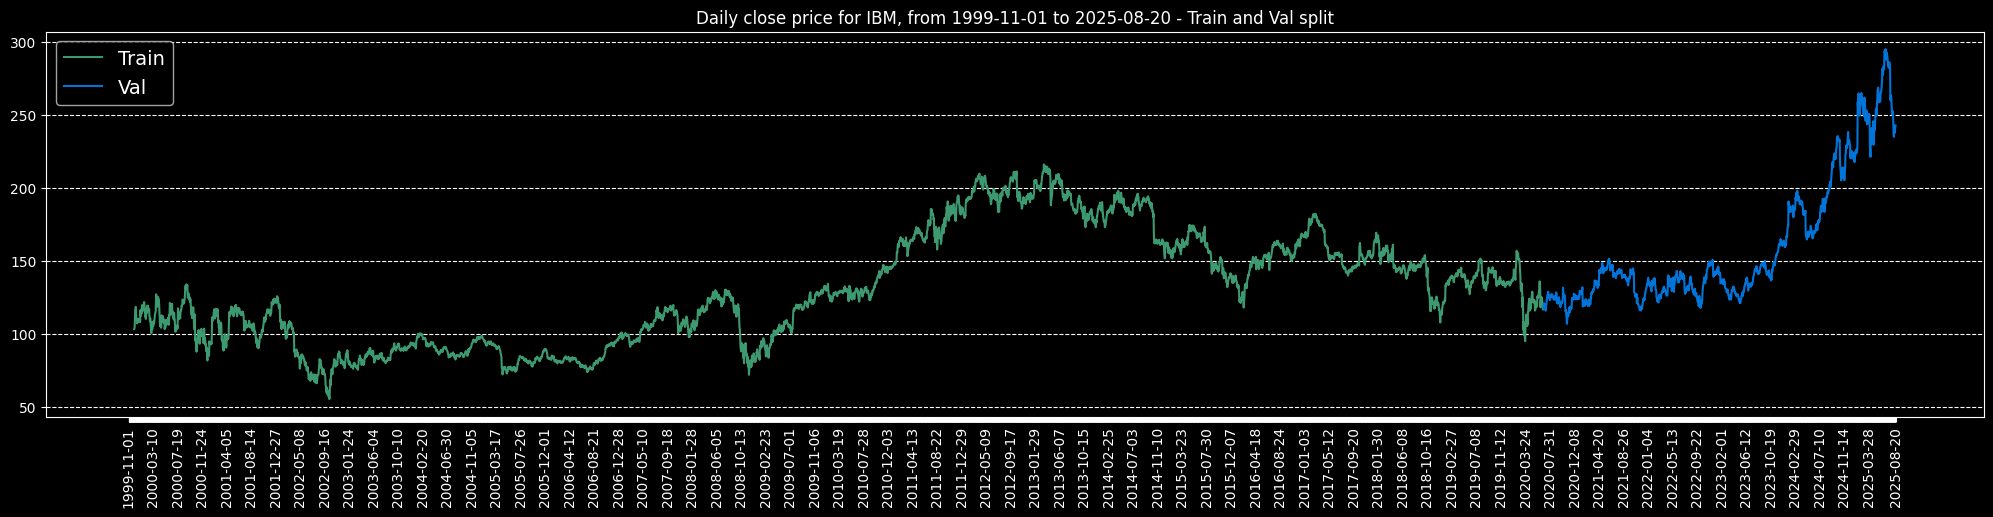

In [ ]:
window_size = config["data"]["window_size"]

to_plot_data_y_train = np.array([None] * num_data_points)
to_plot_data_y_val = np.array([None] * num_data_points)

to_plot_data_y_train[window_size : window_size + split_index] = scaler.inverse_transform(data_y_train) # split_index elements and the first window_size data points are lost  
to_plot_data_y_val[window_size + split_index : ] = scaler.inverse_transform(data_y_val)


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]
for i in range(num_data_points):
    if i == num_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range} - Train and Val split")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14);


### Datasets and DataLoaders

In [22]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(dim=-1) # (batch, sequence (window size)) -> (batch, sequence, features (1)). Only one feature (closing price)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
dataset_train.x[:2], dataset_train.y[0]

Train data shape torch.Size([5176, 20, 1]) torch.Size([5176])
Validation data shape torch.Size([1294, 20, 1]) torch.Size([1294])


(tensor([[[-0.9366],
          [-0.9836],
          [-0.9943],
          [-1.0624],
          [-1.0942],
          [-1.0047],
          [-1.0125],
          [-0.9306],
          [-0.9790],
          [-0.9579],
          [-1.0018],
          [-0.9882],
          [-1.0093],
          [-0.9063],
          [-0.7623],
          [-0.6671],
          [-0.7110],
          [-0.7488],
          [-0.7367],
          [-0.7563]],
 
         [[-0.9836],
          [-0.9943],
          [-1.0624],
          [-1.0942],
          [-1.0047],
          [-1.0125],
          [-0.9306],
          [-0.9790],
          [-0.9579],
          [-1.0018],
          [-0.9882],
          [-1.0093],
          [-0.9063],
          [-0.7623],
          [-0.6671],
          [-0.7110],
          [-0.7488],
          [-0.7367],
          [-0.7563],
          [-0.7837]]]),
 tensor(-0.7837))

In [23]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

## LSTM Model

$$
f_t = \sigma(W_{if} x_t + W_{hf} h_{t-1} + b_f) \\
i_t = \sigma(W_{ii} x_t + W_{hi} h_{t-1} + b_i) \\
\tilde{C}_t = \tanh(W_{iC} x_t + W_{hC} h_{t-1} + b_C) \\
o_t = \sigma(W_{io} x_t + W_{ho} h_{t-1} + b_o)
$$

In PyTorch, all the $W_{i*}$ (input -> gate) matrices are stacked together into weight_ih

All the $W_{h*}$ (hidden -> gate) are stacked together into weight_hh

$$
\begin{bmatrix}
f_t \\
i_t \\
\tilde{C}_t \\
o_t
\end{bmatrix}
=
\begin{bmatrix}
\sigma \\
\sigma \\
\tanh \\
\sigma
\end{bmatrix}
\Big(
W_{ih} x_t + W_{hh} h_{t-1} + b_{ih} + b_{hh}
\Big)
$$


In [25]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(in_features=input_size, out_features=hidden_layer_size)
        self.relu = nn.ReLU()
        # batch_first = True makes input/output (batch_size, seq_len, feature_num) instead of (seq_len, batch_size, feature_num) 
        self.lstm = nn.LSTM(input_size=hidden_layer_size,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout)

        self.dropout = nn.Dropout(p=dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                 nn.init.zeros_(param)
            elif "weight_ih" in name:
                 nn.init.kaiming_normal_(param) # normal distribution scaled to preserve variance across layers
            elif "weight_hh" in name:
                 nn.init.orthogonal_(param) # preserves the gradient norm so it doesn't vanish/explode


    def forward(self, x):

        x = self.linear_1(x) # (batch, seq_len, num_features) -> (batch, seq_len, hidden_layer_size) 
        x = self.relu(x)

        # output has shape (batch, seq_len, hidden_layer_size). Hidden state from last LSTM layer, at every time step
        # h_n has shape (num_layers, batch, hidden_layer_size). Final hidden state for each layer, at the last time step
        # c_n has the same shape as h_n. Final cell state for each layer, at the last time step.
        output, (h_n, c_n) = self.lstm(x)

        x = h_n.transpose(0, 1).reshape(x.shape[0], -1) # (num_layers, batch, hidden_layer_size) -> (batch, num_layers*hidden_layer_size)

        x = self.dropout(x)

        x = self.linear_2(x) # (batch, output_size)
        return x.squeeze(-1)


## Model Training

In [28]:
model = LSTMModel(input_size=config["model"]["input_size"], 
                  hidden_layer_size=config["model"]["lstm_size"], 
                  num_layers=config["model"]["num_lstm_layers"], 
                  dropout=config["model"]["dropout"])

model = model.to(config["training"]["device"])

loss_fn = nn.MSELoss()
optimizer = optim.AdamW(params = model.parameters(),
                        lr=config["training"]["learning_rate"],
                        betas=(0.9, 0.98),
                        eps=1e-9)

scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=config["training"]["scheduler_step_size"],
                                      gamma=0.1)

device = config["training"]["device"]


best_val_loss = float('inf')
best_epoch = 0

for epoch in range(config["training"]["num_epoch"]):
    model.train()
    
    train_loss = 0.0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X) # (batch, 1) -> (batch,). Matches with y
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().item()

    train_loss = train_loss / len(train_dataloader)

    model.eval()

    val_loss = 0.0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            val_pred = model(X)
            val_loss += loss_fn(val_pred, y).item()


    val_loss = val_loss / len(val_dataloader)

    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch:03d}/{config["training"]["num_epoch"]} | train_loss: {train_loss:.6f} | val_loss: {val_loss:.6f} | lr: {current_lr:.6f}")

print(f"Best val loss: {best_val_loss} at epoch {best_epoch}")

# Epoch 053/100 | train_loss: 0.005743 | val_loss: 0.007505 | lr: 0.001000
        

Epoch 000/100 | train_loss: 0.047730 | val_loss: 0.113050 | lr: 0.010000
Epoch 001/100 | train_loss: 0.010761 | val_loss: 0.073829 | lr: 0.010000
Epoch 002/100 | train_loss: 0.009480 | val_loss: 0.058768 | lr: 0.010000
Epoch 003/100 | train_loss: 0.009239 | val_loss: 0.047143 | lr: 0.010000
Epoch 004/100 | train_loss: 0.007741 | val_loss: 0.071441 | lr: 0.010000
Epoch 005/100 | train_loss: 0.008561 | val_loss: 0.063828 | lr: 0.010000
Epoch 006/100 | train_loss: 0.007985 | val_loss: 0.037999 | lr: 0.010000
Epoch 007/100 | train_loss: 0.007640 | val_loss: 0.051365 | lr: 0.010000
Epoch 008/100 | train_loss: 0.008680 | val_loss: 0.022094 | lr: 0.010000
Epoch 009/100 | train_loss: 0.008284 | val_loss: 0.047882 | lr: 0.010000
Epoch 010/100 | train_loss: 0.008726 | val_loss: 0.027278 | lr: 0.010000
Epoch 011/100 | train_loss: 0.007588 | val_loss: 0.021313 | lr: 0.010000
Epoch 012/100 | train_loss: 0.007301 | val_loss: 0.023612 | lr: 0.010000
Epoch 013/100 | train_loss: 0.008181 | val_loss: 0.

## Model Evaluation

### Get Predictions

In [73]:
model.load_state_dict(torch.load("best_model.pth"))

train_preds_list = []
val_preds_list = []

train_eval_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False) # no shuffle

with torch.inference_mode():
    for X, y in train_eval_dataloader:
        X, y = X.to(device), y.to(device)

        train_pred = model(X)
        train_preds_list.append(train_pred)


    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)

        val_pred = model(X)
        val_preds_list.append(val_pred)

train_preds = torch.cat(train_preds_list).cpu().detach().numpy()
val_preds = torch.cat(val_preds_list).cpu().detach().numpy()

### Plot Predictions

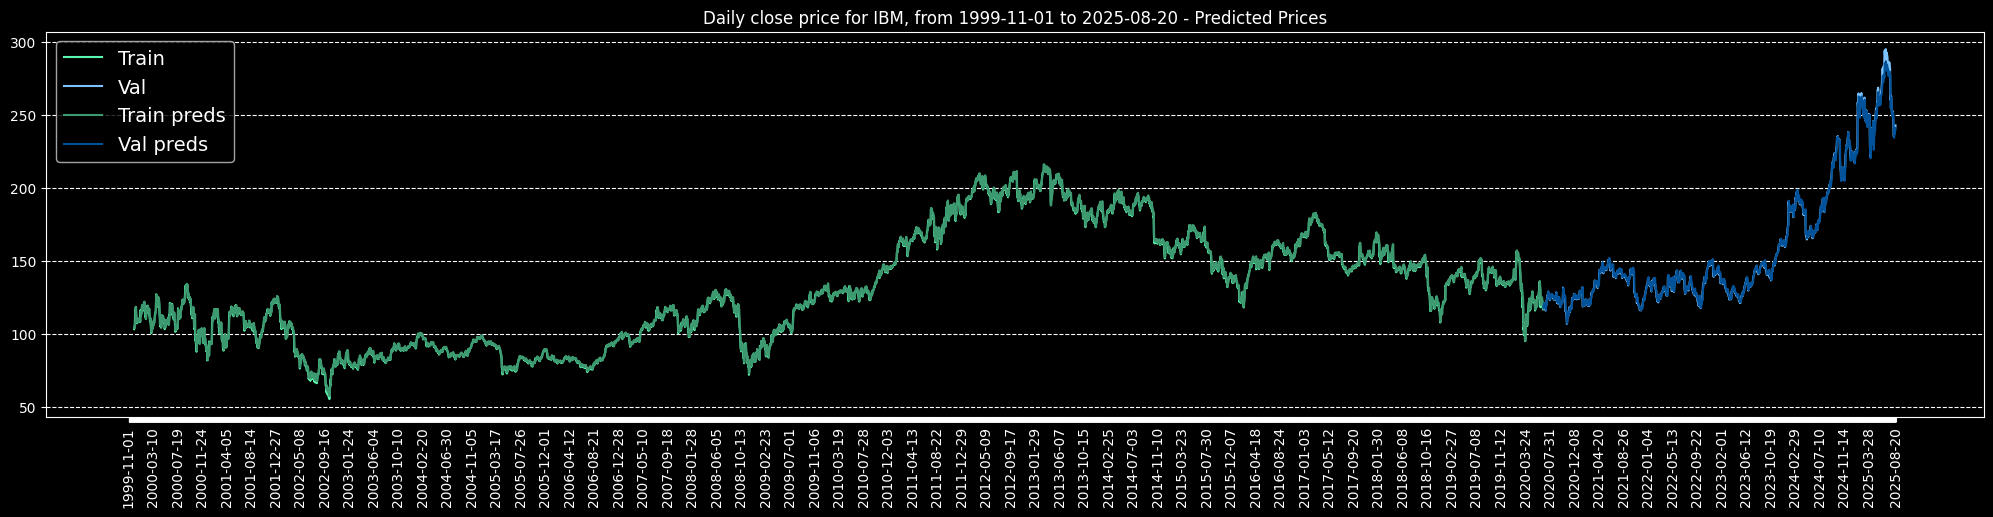

In [74]:
window_size = config["data"]["window_size"]


to_plot_y_train_preds = np.array([None] * num_data_points)
to_plot_y_val_preds = np.array([None] * num_data_points)

to_plot_y_train_preds[window_size : window_size + split_index] = scaler.inverse_transform(train_preds)
to_plot_y_val_preds[window_size + split_index : ] = scaler.inverse_transform(val_preds)


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])

plt.plot(data_dates, to_plot_y_train_preds, label = "Train preds", color=config["plots"]["color_pred_train"])
plt.plot(data_dates, to_plot_y_val_preds, label = "Val preds", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]
for i in range(num_data_points):
    if i == num_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range} - Predicted Prices")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Zoom in on Val Preds

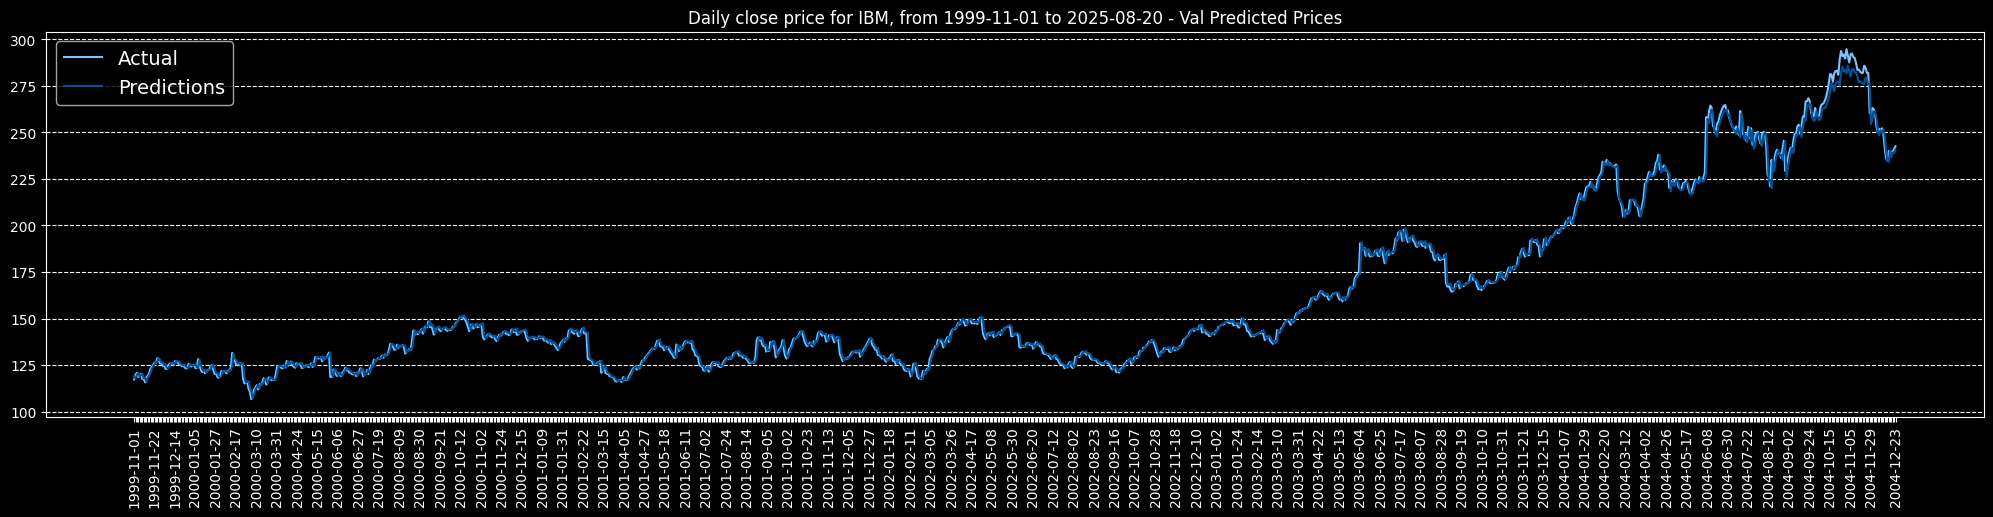

In [81]:
to_plot_y_val_preds_zoomed = scaler.inverse_transform(val_preds)
to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)

data_dates_val = data_dates[window_size + split_index : ]

fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_val, to_plot_data_y_val_subset, label = "Actual", color=config["plots"]["color_val"])
plt.plot(data_dates_val, to_plot_y_val_preds_zoomed, label = "Predictions", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_val_data_points = len(data_dates_val)

for i in range(num_val_data_points):
    if i == num_val_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_val_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range} - Val Predicted Prices")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)
